In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Загрузка данных
print("="*60)
print("ЗАГРУЗКА ДАННЫХ")
print("="*60)

df_train = pd.read_csv('GiveMeSomeCredit-training.csv', index_col=0)
df_test = pd.read_csv('GiveMeSomeCredit-testing.csv', index_col=0)

print(f"Размер обучающей выборки: {df_train.shape}")
print(f"Размер тестовой выборки: {df_test.shape}")

print("\nПервые строки обучающих данных:")
print(df_train.head())

print("\nИнформация о типах данных:")
print(df_train.info())

print("\nСтатистика по признакам:")
print(df_train.describe())


ЗАГРУЗКА ДАННЫХ
Размер обучающей выборки: (150000, 11)
Размер тестовой выборки: (101503, 11)

Первые строки обучающих данных:
   SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                 1                              0.766127   45   
2                 0                              0.957151   40   
3                 0                              0.658180   38   
4                 0                              0.233810   30   
5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     2   0.802982         9120.0   
2                                     0   0.121876         2600.0   
3                                     1   0.085113         3042.0   
4                                     0   0.036050         3300.0   
5                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \

In [4]:
print("="*60)
print("АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("="*60)

missing_train = pd.DataFrame({
    'Столбец': df_train.columns,
    'Количество пропусков': df_train.isnull().sum().values,
    'Процент (%)': (df_train.isnull().sum().values / len(df_train) * 100).round(2)
})

missing_test = pd.DataFrame({
    'Столбец': df_test.columns,
    'Количество пропусков': df_test.isnull().sum().values,
    'Процент (%)': (df_test.isnull().sum().values / len(df_test) * 100).round(2)
})

print("\nПропущенные значения в обучающей выборке:")
print(missing_train[missing_train['Количество пропусков'] > 0].to_string(index=False))

print("\nПропущенные значения в тестовой выборке:")
print(missing_test[missing_test['Количество пропусков'] > 0].to_string(index=False))


АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

Пропущенные значения в обучающей выборке:
           Столбец  Количество пропусков  Процент (%)
     MonthlyIncome                 29731        19.82
NumberOfDependents                  3924         2.62

Пропущенные значения в тестовой выборке:
           Столбец  Количество пропусков  Процент (%)
  SeriousDlqin2yrs                101503       100.00
     MonthlyIncome                 20103        19.81
NumberOfDependents                  2626         2.59


In [5]:
print("="*60)
print("ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("="*60)

# Создание копий для избежания FutureWarning
df_train = df_train.copy()
df_test = df_test.copy()

# Заполнение пропусков медианой
for col in df_train.columns:
    if df_train[col].isnull().sum() > 0:
        median_value = df_train[col].median()
        df_train[col] = df_train[col].fillna(median_value)
        print(f"✓ Заполнены пропуски в '{col}' медианой: {median_value}")

# Заполнение пропусков в тестовой выборке медианами из обучающей
for col in df_test.columns:
    if df_test[col].isnull().sum() > 0:
        median_value = df_train[col].median()
        df_test[col] = df_test[col].fillna(median_value)
        print(f"✓ Заполнены пропуски в '{col}' (test) медианой из train: {median_value}")

print(f"\nПосле обработки пропусков:")
print(f"Обучающая выборка: {df_train.shape}")
print(f"Тестовая выборка: {df_test.shape}")
print(f"Пропусков в train: {df_train.isnull().sum().sum()}")
print(f"Пропусков в test: {df_test.isnull().sum().sum()}")


ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
✓ Заполнены пропуски в 'MonthlyIncome' медианой: 5400.0
✓ Заполнены пропуски в 'NumberOfDependents' медианой: 0.0
✓ Заполнены пропуски в 'SeriousDlqin2yrs' (test) медианой из train: 0.0
✓ Заполнены пропуски в 'MonthlyIncome' (test) медианой из train: 5400.0
✓ Заполнены пропуски в 'NumberOfDependents' (test) медианой из train: 0.0

После обработки пропусков:
Обучающая выборка: (150000, 11)
Тестовая выборка: (101503, 11)
Пропусков в train: 0
Пропусков в test: 0


In [6]:
print("="*60)
print("РАЗДЕЛЕНИЕ ДАННЫХ")
print("="*60)

# Разделение на X и y
X_train = df_train.drop('SeriousDlqin2yrs', axis=1)
y_train = df_train['SeriousDlqin2yrs']

X_test = df_test.drop('SeriousDlqin2yrs', axis=1)
y_test = df_test['SeriousDlqin2yrs']

print(f"Признаки обучающей выборки: {X_train.shape}")
print(f"Целевая переменная обучающей выборки: {y_train.shape}")
print(f"Признаки тестовой выборки: {X_test.shape}")
print(f"Целевая переменная тестовой выборки: {y_test.shape}")

print(f"\nСписок признаков:")
for i, col in enumerate(X_train.columns, 1):
    print(f"  {i}. {col}")

print(f"\nРаспределение целевой переменной в обучающей выборке:")
print(y_train.value_counts())
print(f"\nПропорция классов:")
print(y_train.value_counts(normalize=True))


РАЗДЕЛЕНИЕ ДАННЫХ
Признаки обучающей выборки: (150000, 10)
Целевая переменная обучающей выборки: (150000,)
Признаки тестовой выборки: (101503, 10)
Целевая переменная тестовой выборки: (101503,)

Список признаков:
  1. RevolvingUtilizationOfUnsecuredLines
  2. age
  3. NumberOfTime30-59DaysPastDueNotWorse
  4. DebtRatio
  5. MonthlyIncome
  6. NumberOfOpenCreditLinesAndLoans
  7. NumberOfTimes90DaysLate
  8. NumberRealEstateLoansOrLines
  9. NumberOfTime60-89DaysPastDueNotWorse
  10. NumberOfDependents

Распределение целевой переменной в обучающей выборке:
SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64

Пропорция классов:
SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64


In [7]:
print("="*60)
print("СТАНДАРТИЗАЦИЯ ДАННЫХ")
print("="*60)

X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

print(f"Размер стандартизированных данных (train): {X_train_scaled.shape}")
print(f"Размер стандартизированных данных (test): {X_test_scaled.shape}")
print(f"\nСреднее значение после стандартизации (train): {X_train_scaled.mean():.10f}")
print(f"Стандартное отклонение (train): {X_train_scaled.std():.10f}")
print(f"Минимум: {X_train_scaled.min():.4f}")
print(f"Максимум: {X_train_scaled.max():.4f}")


СТАНДАРТИЗАЦИЯ ДАННЫХ
Размер стандартизированных данных (train): (150000, 10)
Размер стандартизированных данных (test): (101503, 10)

Среднее значение после стандартизации (train): 0.0000000000
Стандартное отклонение (train): 1.0000000000
Минимум: -3.5402
Максимум: 232.9131


In [8]:
print("="*60)
print("АНАЛИЗ ГЛАВНЫХ КОМПОНЕНТ (PCA)")
print("="*60)

# Создание и обучение PCA на всех компонентах
pca_full = PCA(svd_solver='full')
pca_full.fit(X_train_scaled)

# Объяснённая дисперсия каждой компонентой
print("\nОбъяснённая дисперсия каждой компонентой:")
for i, var in enumerate(pca_full.explained_variance_ratio_, 1):
    print(f"Компонента {i:2d}: {var:.6f} ({var*100:.2f}%)")

# Кумулятивная дисперсия
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
print("\nКумулятивная объяснённая дисперсия:")
for i in [1, 2, 3, 4, 5, len(cumulative_var)]:
    if i <= len(cumulative_var):
        print(f"{i:2d} компонент: {cumulative_var[i-1]:.6f} ({cumulative_var[i-1]*100:.2f}%)")

# Определение количества компонент для 80%, 85%, 90%, 95% дисперсии
thresholds = [0.80, 0.85, 0.90, 0.95]
print("\nКоличество компонент для заданной дисперсии:")
for thresh in thresholds:
    n_comp = np.argmax(cumulative_var >= thresh) + 1
    print(f"  {thresh*100:.0f}% дисперсии: {n_comp} компонент")

# Выбираем 80% для дальнейшей работы
n_components_80 = np.argmax(cumulative_var >= 0.80) + 1
print(f"\n>>> Выбрано компонент для 80% дисперсии: {n_components_80}")


АНАЛИЗ ГЛАВНЫХ КОМПОНЕНТ (PCA)

Объяснённая дисперсия каждой компонентой:
Компонента  1: 0.299500 (29.95%)
Компонента  2: 0.153743 (15.37%)
Компонента  3: 0.123589 (12.36%)
Компонента  4: 0.101805 (10.18%)
Компонента  5: 0.100113 (10.01%)
Компонента  6: 0.092241 (9.22%)
Компонента  7: 0.072289 (7.23%)
Компонента  8: 0.054318 (5.43%)
Компонента  9: 0.001721 (0.17%)
Компонента 10: 0.000681 (0.07%)

Кумулятивная объяснённая дисперсия:
 1 компонент: 0.299500 (29.95%)
 2 компонент: 0.453243 (45.32%)
 3 компонент: 0.576832 (57.68%)
 4 компонент: 0.678637 (67.86%)
 5 компонент: 0.778750 (77.88%)
10 компонент: 1.000000 (100.00%)

Количество компонент для заданной дисперсии:
  80% дисперсии: 6 компонент
  85% дисперсии: 6 компонент
  90% дисперсии: 7 компонент
  95% дисперсии: 8 компонент

>>> Выбрано компонент для 80% дисперсии: 6


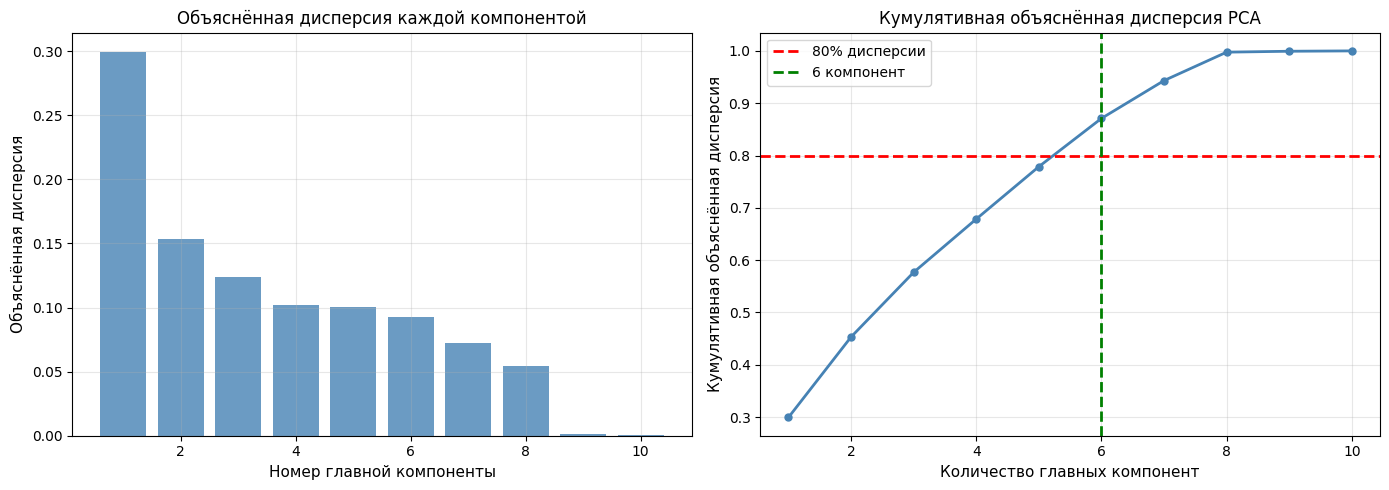

График сохранён в файл 'pca_explained_variance.png'


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Объяснённая дисперсия каждой компонентой
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
            pca_full.explained_variance_ratio_, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Номер главной компоненты', fontsize=11)
axes[0].set_ylabel('Объяснённая дисперсия', fontsize=11)
axes[0].set_title('Объяснённая дисперсия каждой компонентой', fontsize=12)
axes[0].grid(True, alpha=0.3)

# График 2: Кумулятивная дисперсия
axes[1].plot(range(1, len(cumulative_var) + 1), cumulative_var, 
             marker='o', linewidth=2, markersize=5, color='steelblue')
axes[1].axhline(y=0.80, color='red', linestyle='--', linewidth=2, label='80% дисперсии')
axes[1].axvline(x=n_components_80, color='green', linestyle='--', linewidth=2, 
                label=f'{n_components_80} компонент')
axes[1].set_xlabel('Количество главных компонент', fontsize=11)
axes[1].set_ylabel('Кумулятивная объяснённая дисперсия', fontsize=11)
axes[1].set_title('Кумулятивная объяснённая дисперсия PCA', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.savefig('pca_explained_variance.png', dpi=300, bbox_inches='tight')
plt.show()
print("График сохранён в файл 'pca_explained_variance.png'")


In [10]:
print("="*60)
print("ОБУЧЕНИЕ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ БЕЗ PCA")
print("="*60)

start_time = time.time()
lr_original = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_original.fit(X_train_scaled, y_train)
training_time_original = time.time() - start_time

# Предсказание
y_pred_original = lr_original.predict(X_test_scaled)
y_pred_proba_original = lr_original.predict_proba(X_test_scaled)[:, 1]

# Оценка качества
accuracy_original = accuracy_score(y_test, y_pred_original)

print(f"Количество признаков: {X_train.shape[1]}")
print(f"Время обучения: {training_time_original:.4f} секунд")
print(f"Точность (Accuracy): {accuracy_original:.4f}")

print("\nОтчёт классификации:")
print(classification_report(y_test, y_pred_original, target_names=['Класс 0', 'Класс 1']))

print("\nМатрица ошибок:")
cm_original = confusion_matrix(y_test, y_pred_original)
print(cm_original)


ОБУЧЕНИЕ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ БЕЗ PCA
Количество признаков: 10
Время обучения: 4.0971 секунд
Точность (Accuracy): 0.9960

Отчёт классификации:
              precision    recall  f1-score   support

     Класс 0       1.00      1.00      1.00    101503
     Класс 1       0.00      0.00      0.00         0

    accuracy                           1.00    101503
   macro avg       0.50      0.50      0.50    101503
weighted avg       1.00      1.00      1.00    101503


Матрица ошибок:
[[101098    405]
 [     0      0]]


C:\Users\Sergey\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Sergey\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Sergey\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

In [22]:
print("="*60)
print(f"ОБУЧЕНИЕ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ С PCA ({n_components_80} компонент)")
print("="*60)

# Применение PCA с выбранным количеством компонент
pca_reduced = PCA(n_components=n_components_80, svd_solver='full')
X_train_pca = pca_reduced.fit_transform(X_train_scaled)
X_test_pca = pca_reduced.transform(X_test_scaled)

print(f"Размер данных после PCA (train): {X_train_pca.shape}")
print(f"Размер данных после PCA (test): {X_test_pca.shape}")
print(f"Объяснённая дисперсия: {pca_reduced.explained_variance_ratio_.sum():.4f}")

# Обучение модели
start_time = time.time()
lr_pca = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_pca.fit(X_train_pca, y_train)
training_time_pca = time.time() - start_time

# Предсказание
y_pred_pca = lr_pca.predict(X_test_pca)
y_pred_proba_pca = lr_pca.predict_proba(X_test_pca)[:, 1]

# Оценка качества
accuracy_pca = accuracy_score(y_test, y_pred_pca)

print(f"\nКоличество признаков: {n_components_80}")
print(f"Время обучения: {training_time_pca:.4f} секунд")
print(f"Точность (Accuracy): {accuracy_pca:.4f}")

print("\nОтчёт классификации:")
print(classification_report(y_test, y_pred_pca, target_names=['Класс 0', 'Класс 1']))

print("\nМатрица ошибок:")
cm_pca = confusion_matrix(y_test, y_pred_pca)
print(cm_pca)


ОБУЧЕНИЕ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ С PCA (6 компонент)
Размер данных после PCA (train): (150000, 6)
Размер данных после PCA (test): (101503, 6)
Объяснённая дисперсия: 0.8710

Количество признаков: 6
Время обучения: 2.3762 секунд
Точность (Accuracy): 0.9979

Отчёт классификации:
              precision    recall  f1-score   support

     Класс 0       1.00      1.00      1.00    101503
     Класс 1       0.00      0.00      0.00         0

    accuracy                           1.00    101503
   macro avg       0.50      0.50      0.50    101503
weighted avg       1.00      1.00      1.00    101503


Матрица ошибок:
[[101289    214]
 [     0      0]]


C:\Users\Sergey\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Sergey\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Sergey\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

In [23]:
print("="*60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*60)

comparison_df = pd.DataFrame({
    'Метод': ['Без PCA', f'С PCA ({n_components_80} компонент)'],
    'Количество признаков': [X_train.shape[1], n_components_80],
    'Время обучения (сек)': [training_time_original, training_time_pca],
    'Точность (Accuracy)': [accuracy_original, accuracy_pca],
    'Ускорение обучения (раз)': [1.0, training_time_original / training_time_pca],
    'Сжатие признаков (%)': [0, (1 - n_components_80 / X_train.shape[1]) * 100]
})

print(comparison_df.to_string(index=False))

# Сохранение результатов
comparison_df.to_excel('pca_comparison_results.xlsx', index=False, sheet_name='Сравнение')
print("\nРезультаты сохранены в файл 'pca_comparison_results.xlsx'")

# Дополнительная статистика
print("\n" + "="*60)
print("ИТОГОВАЯ СТАТИСТИКА")
print("="*60)
print(f"Снижение размерности: с {X_train.shape[1]} до {n_components_80} признаков")
print(f"Сокращение: {(1 - n_components_80 / X_train.shape[1]) * 100:.1f}%")
print(f"Изменение точности: {(accuracy_pca - accuracy_original):.4f} ({(accuracy_pca - accuracy_original)*100:.2f}%)")
print(f"Ускорение обучения: {training_time_original / training_time_pca:.2f}x")


СРАВНЕНИЕ РЕЗУЛЬТАТОВ
              Метод  Количество признаков  Время обучения (сек)  Точность (Accuracy)  Ускорение обучения (раз)  Сжатие признаков (%)
            Без PCA                    10              4.065208             0.996010                  1.000000                   0.0
С PCA (6 компонент)                     6              2.376209             0.997892                  1.710796                  40.0

Результаты сохранены в файл 'pca_comparison_results.xlsx'

ИТОГОВАЯ СТАТИСТИКА
Снижение размерности: с 10 до 6 признаков
Сокращение: 40.0%
Изменение точности: 0.0019 (0.19%)
Ускорение обучения: 1.71x
